<h1>Pothole-Traffic Analysis</h1>

### Table of contents
1. [Introduction](#introduction)
2. [Data Preprocessing](#preprocessing)
    1. [Segment](#proc_seg)
    2. [Region](#proc_reg)
3. [Data Exploration](#exploration) 
    


## Introduction <a name="introduction"></a>

Ideas and parts of code referenced from: 

- https://github.com/vingkan/crash/blob/master/Traffic%20Crash%20Sample.ipynb

- https://github.com/dingqixin/correlation-traffic-violations-congestion-level/blob/master/FinalProject.ipynb

- https://github.com/mdhanna/Chicago_Pothole_Analysis

<b>Question</b>: Is there a relationship between traffic congestion (average and bus) and pothole occurence?

<b>Hypothesis</b>: There will be more potholes on streets with a lower traffic speed (higher congestion)


<b>Datasets Used</b>

- 311 Pothole Service Requests <br /> Link: https://data.cityofchicago.org/Service-Requests/311-Service-Requests-Pot-Holes-Reported-Historical/7as2-ds3y) <br /> Contains data on pothole requests. 


- Historical Congestion Estimates by Segment 2011 - 2018 <br /> Link: https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Historical-Congestion-Esti/77hq-huss <br /> Contains estimated speeds in different street segments. According to the CDOT this is from 2011 to 2018, however most of the speed data from 2011/2012 is unknown. 


- Historical Congestion Estimates by Region 2013 - 2018 <br /> Link: https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Historical-Congestion-Esti/emtn-qqdi <br /> Contains estimated speeds in different regions, from 2013 - 2018. 


- Congestion Estimates by Regions <br /> https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Congestion-Estimates-by-Re/t2qc-9pjd <br /> Contains region ID, bounding longitude/latitude in four directions. 


- Congestion Estimates by Segments <br /> https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Congestion-Estimates-by-Se/n4j6-wkkf <br /> Contains segment ID, start longitude/latitude, end longitude/latitude





## Data Preprocessing <a name="preprocessing"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
from scipy import stats
pd.options.mode.chained_assignment = None
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
import ast

Reading in the dataframe

- Deleted duplicate requests

- Changed dates to datetime

- Deleted ward 0

In [2]:
df = pd.read_csv("Downloads/497_Data/potholes.csv")
df.columns = ['Creation Date', 'Status', 'Completion Date', 'Service Request Number', 'Type of Service Request', 'Current Activity', 'Most Recent Action', 'Number of Potholes Filled on Block', 'Street Address', 'Zip', 'X Coordinate', 'Y Coordinate', 'Ward', 'Police District', 'Community Area', 'SSA', 'Latitude', 'Longitude', 'Location']
df['Creation Date'] =  pd.to_datetime(df['Creation Date'])
df['Completion Date'] =  pd.to_datetime(df['Completion Date'])
df = df[~df['Status'].str.contains("Dup")]
df = df[(df['Ward']!=0)]
df = df.reset_index(drop=True)
df.head()

/home/anna/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Creation Date,Status,Completion Date,Service Request Number,Type of Service Request,Current Activity,Most Recent Action,Number of Potholes Filled on Block,Street Address,Zip,X Coordinate,Y Coordinate,Ward,Police District,Community Area,SSA,Latitude,Longitude,Location
0,2011-01-01,Completed,2011-01-03,11-00002021,Pot Hole in Street,Dispatch Crew,Pothole Patched,5.0,1642 W 99TH ST,60643.0,1.166945e+06,1.839061e+06,19.0,22.0,72.0,NaN,41.714035,-87.665096,"(41.71403466751051, -87.66509581640723)"
1,2011-01-01,Completed,2011-01-03,11-00002273,Pot Hole in Street,Dispatch Crew,Pothole Patched,7.0,3500 S PULASKI RD,60623.0,1.150258e+06,1.881340e+06,22.0,10.0,30.0,NaN,41.830224,-87.724352,"(41.830223541014355, -87.7243519544564)"
2,2011-01-01,Completed,2011-01-03,11-00002650,Pot Hole in Street,Dispatch Crew,Pothole Patched,5.0,7851 S DR MARTIN LUTHER KING JR DR,60619.0,1.180265e+06,1.853038e+06,6.0,6.0,69.0,51.0,41.751434,-87.614820,"(41.75143385051753, -87.61481960290558)"
3,2011-01-01,Completed,2011-01-03,11-00002654,Pot Hole in Street,Dispatch Crew,Pothole Patched,3.0,15 E 79TH ST,60619.0,1.177809e+06,1.852641e+06,6.0,6.0,44.0,NaN,41.750865,-87.623890,"(41.75086472111055, -87.62388985583482)"
4,2011-01-01,Completed,2011-01-03,11-00002656,Pot Hole in Street,Dispatch Crew,Pothole Patched,4.0,359 E 79TH ST,60619.0,1.179971e+06,1.852707e+06,6.0,6.0,44.0,51.0,41.750992,-87.615824,"(41.75099208108744, -87.61582439398472)"


<b>Segment</b> <a name="proc_seg"></a>

In [3]:
df_seg = pd.read_csv('Downloads/497_Data/segments.csv')
df_seg.columns = ['SEGMENTID', 'STREET', 'DIRECTION', 'FROM_STREET', 'TO_STREET',
       'LENGTH', 'STREET_HEADING', ' COMMENTS', 'START_LONGITUDE',
       'START_LATITUDE', 'END_LONGITUDE', 'END_LATITUDE', 'CURRENT_SPEED',
       'LAST_UPDATED']
chunksize = 100000
TextFileReader = pd.read_csv('Downloads/497_Data/historical_segments.csv', sep=',', chunksize=chunksize, iterator=True)
df_hist_seg = pd.concat(TextFileReader, ignore_index=True)

For each row in the 311 potholes dataset I have iterated over each row df_seg to find the [min_lon, max_lon], [min_lat, max_lat] that a specific pothole request falls into, labeling it with the street segment ID. For performance reasons the result has been saved into a local csv. 

In [4]:
df_ph = df.drop(['Status', 'Completion Date', 'Type of Service Request', 'Current Activity', 'Most Recent Action', 'Zip', 'Police District', 'Community Area', 'SSA', 'Location', 'X Coordinate', 'Y Coordinate'], axis=1)
df_ph = df_ph.loc[(df_ph['Creation Date'].dt.year>=2011) & (df_ph['Creation Date'].dt.year<=2018)]
df_ph = df_ph[(df_ph['Longitude'] <= -87.524296) & (df_ph['Longitude'] >= -87.904884) & (df_ph['Latitude'] <= 42.012985) & (df_ph['Latitude'] >= 41.658970)]
df_ph.head()

In [5]:
df_seg['minLon'] = pd.np.minimum(df_seg['START_LONGITUDE'],df_seg['END_LONGITUDE'])
df_seg['maxLon'] = pd.np.maximum(df_seg['START_LONGITUDE'],df_seg['END_LONGITUDE'])
df_seg['minLat'] = pd.np.minimum(df_seg['START_LATITUDE'],df_seg['END_LATITUDE'])
df_seg['maxLat'] = pd.np.maximum(df_seg['START_LATITUDE'],df_seg['END_LATITUDE'])
df_seg = df_seg.drop_duplicates(subset=['START_LATITUDE','START_LONGITUDE','END_LONGITUDE','END_LATITUDE'], keep='first')
df_seg.head()

In [6]:
df_ph.assign(SEGMENTID = 0)
for xrow in df_ph.itertuples():
    for yrow in df_seg.itertuples():
        if ((xrow.Latitude <= yrow.maxLat) and (xrow.Latitude >= yrow.minLat) and (xrow.Longitude <= yrow.maxLon) and (xrow.Longitude >= yrow.minLon)):
            df_ph.at[xrow.Index,'SEGMENTID']=yrow.SEGMENTID
            break
#df_ph.to_csv("PotholeSeg.csv", index=False)

In [7]:
df_pseg = pd.read_csv("Downloads/497_Data/PotholeSeg.csv")
df_pseg = df_pseg.dropna(subset=['SEGMENTID'])
df_pseg['Creation Date'] =  pd.to_datetime(df_pseg['Creation Date'])
df_pseg = df_pseg.rename(columns={'Creation Date': 'DATE'})
df_pseg.head()

,DATE,Service Request Number,Number of Potholes Filled on Block,Street Address,Ward,Latitude,Longitude,SEGMENTID
1,2011-01-01,11-00002273,7.0,3500 S PULASKI RD,22.0,41.830224,-87.724352,76.0
2,2011-01-01,11-00002650,5.0,7851 S DR MARTIN LUTHER KING JR DR,6.0,41.751434,-87.614820,687.0
3,2011-01-01,11-00002654,3.0,15 E 79TH ST,6.0,41.750865,-87.623890,411.0
4,2011-01-01,11-00002656,4.0,359 E 79TH ST,6.0,41.750992,-87.615824,411.0
7,2011-01-01,11-00003121,2.0,800 N LAKE SHORE DR,42.0,41.896828,-87.617208,591.0


We group each street segment by date and segment ID to get the average speed of the street segment. 

In [8]:
avgspeed_seg = df_hist_seg.groupby(['TIME','SEGMENTID'])['SPEED'].mean().to_frame('avg_speed').reset_index()
avgspeed_seg['TIME'] = pd.to_datetime(avgspeed_seg['TIME'], format='%m/%d/%Y %I:%M:%S %p').dt.date
avgspeed_seg.columns = ['DATE','SEGMENTID','avg_speed']
avgspeed_seg['DATE'] = pd.to_datetime(avgspeed_seg['DATE'])
avgspeed_seg = avgspeed_seg[(avgspeed_seg['avg_speed']>=0)] #get rid of rows where speed = -1, representing uncertainty about the speed
avgspeed_seg.head()

,DATE,SEGMENTID,avg_speed
0,2013-01-15,1,14.929577
1,2013-01-15,2,18.570423
2,2013-01-15,3,18.626761
3,2013-01-15,4,19.591549
4,2013-01-15,5,21.852113


The result is pothole data matched to street segment and estimated average speed, by month

In [9]:
avgspeed_seg_month = avgspeed_seg.set_index('DATE').groupby([pd.Grouper(freq="MS"), pd.Grouper("SEGMENTID")]).mean().reset_index()
df_pseg_month = df_pseg.set_index('DATE').groupby([pd.Grouper(freq="MS"), pd.Grouper("SEGMENTID"), pd.Grouper("Ward")])['Service Request Number'].count().reset_index()
df_merged_month = pd.merge(df_pseg_month,avgspeed_seg_month,on = ['DATE','SEGMENTID'])
df_merged_month.head()

,DATE,SEGMENTID,Ward,Service Request Number,avg_speed
0,2013-01-01,411.0,6.0,1,17.920728
1,2013-01-01,591.0,42.0,20,6.150345
2,2013-01-01,525.0,41.0,1,6.041398
3,2013-01-01,825.0,45.0,4,22.863121
4,2013-01-01,502.0,12.0,11,17.756065


In [10]:
avgspeed_seg_year = avgspeed_seg.set_index('DATE').groupby([pd.Grouper(freq="Y"), pd.Grouper("SEGMENTID")]).mean().reset_index()
df_pseg_year = df_pseg.set_index('DATE').groupby([pd.Grouper(freq="Y"), pd.Grouper("SEGMENTID"), pd.Grouper("Ward")])['Service Request Number'].count().reset_index()
df_merged_year = pd.merge(df_pseg_year,avgspeed_seg_year,on = ['DATE','SEGMENTID'])
df_merged_year.head()

,DATE,SEGMENTID,Ward,Service Request Number,avg_speed
0,2013-12-31,76.0,22.0,6,16.647233
1,2013-12-31,411.0,6.0,19,17.730421
2,2013-12-31,591.0,42.0,58,6.267880
3,2013-12-31,285.0,38.0,2,14.780157
4,2013-12-31,525.0,41.0,16,6.442550


<b>Region</b> <a name="proc_reg"></a>

Converting Longitude and Latitude into shapely Point geometries

In [11]:
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
gdf_ph = gpd.GeoDataFrame(df, geometry=geometry)
gdf_ph  = gdf_ph.drop(['Latitude', 'Longitude'], axis=1)
gdf_ph.head()

,Creation Date,Status,Completion Date,Service Request Number,Type of Service Request,Current Activity,Most Recent Action,Number of Potholes Filled on Block,Street Address,Zip,X Coordinate,Y Coordinate,Ward,Police District,Community Area,SSA,Location,geometry
0,2011-01-01,Completed,2011-01-03,11-00002021,Pot Hole in Street,Dispatch Crew,Pothole Patched,5.0,1642 W 99TH ST,60643.0,1.166945e+06,1.839061e+06,19.0,22.0,72.0,NaN,"(41.71403466751051, -87.66509581640723)",POINT (-87.66509581640724 41.71403466751051)
1,2011-01-01,Completed,2011-01-03,11-00002273,Pot Hole in Street,Dispatch Crew,Pothole Patched,7.0,3500 S PULASKI RD,60623.0,1.150258e+06,1.881340e+06,22.0,10.0,30.0,NaN,"(41.830223541014355, -87.7243519544564)",POINT (-87.72435195445641 41.83022354101436)
2,2011-01-01,Completed,2011-01-03,11-00002650,Pot Hole in Street,Dispatch Crew,Pothole Patched,5.0,7851 S DR MARTIN LUTHER KING JR DR,60619.0,1.180265e+06,1.853038e+06,6.0,6.0,69.0,51.0,"(41.75143385051753, -87.61481960290558)",POINT (-87.61481960290558 41.75143385051753)
3,2011-01-01,Completed,2011-01-03,11-00002654,Pot Hole in Street,Dispatch Crew,Pothole Patched,3.0,15 E 79TH ST,60619.0,1.177809e+06,1.852641e+06,6.0,6.0,44.0,NaN,"(41.75086472111055, -87.62388985583482)",POINT (-87.6238898558348 41.75086472111055)
4,2011-01-01,Completed,2011-01-03,11-00002656,Pot Hole in Street,Dispatch Crew,Pothole Patched,4.0,359 E 79TH ST,60619.0,1.179971e+06,1.852707e+06,6.0,6.0,44.0,51.0,"(41.75099208108744, -87.61582439398472)",POINT (-87.61582439398472 41.75099208108744)


Because a shapefile of the 29 designated traffic regions was unavailable, directional lat/long boundaries were transformed into NW, NE, SE, SW points and then transformed into a polygon that can serve as a bounding geometry in order to map pothole requests. 


In [12]:
def f(x):    
    pointList = [x[0], x[1], x[2], x[3]]
    return Polygon([[p.x, p.y] for p in pointList])

df_poly = pd.read_csv("Downloads/497_Data/regions.csv")

df_poly['NW'] = [Point(xy) for xy in zip(df_poly[' WEST'], df_poly[' NORTH'])]
df_poly['NE'] = [Point(xy) for xy in zip(df_poly[' EAST'], df_poly[' NORTH'])]
df_poly['SW'] = [Point(xy) for xy in zip(df_poly[' WEST'], df_poly[' SOUTH'])]
df_poly['SE'] = [Point(xy) for xy in zip(df_poly[' EAST'], df_poly[' SOUTH'])]

df_poly = df_poly.drop(columns=[' WEST', ' EAST', ' SOUTH', ' NORTH', ' DESCRIPTION', ' CURRENT_SPEED', 'REGION', ' LAST_UPDATED'])

df_poly['geometry'] = df_poly[['NW','NE','SE','SW']].apply(f, axis=1)
df_poly = df_poly.drop(columns=['NW', 'NE', 'SE', 'SW'])
gdf_poly = gpd.GeoDataFrame(df_poly)
gdf_poly = gdf_poly.rename(columns={' REGION_ID': 'REGION_ID'})
gdf_poly.head()

,REGION_ID,geometry
0,11,"POLYGON ((-87.69161700000001 41.910561, -87.64..."
1,8,"POLYGON ((-87.67459000000001 41.960669, -87.61..."
2,28,"POLYGON ((-87.662508 41.677477, -87.5244359999..."
3,3,"POLYGON ((-87.747456 41.997946, -87.6745900000..."
4,7,"POLYGON ((-87.747456 41.931841, -87.6745900000..."


The result is pothole data matched to traffic region. 

In [13]:
df_reg = gpd.sjoin(gdf_ph, gdf_poly, op="within").reset_index(drop=True)
df_reg = df_reg.drop(columns=['Status', 'Completion Date', 'Type of Service Request', 'Current Activity', 'Most Recent Action', 'Zip', 'X Coordinate', 'Y Coordinate', 'Police District', 'Ward', 'Community Area', 'SSA', 'geometry', 'index_right'])
#df_reg = df_reg.set_index('Creation Date')
df_reg = df_reg.rename(columns={'Creation Date': 'DATE', ' REGION_ID':'REGION_ID'})

In [14]:
chunksize = 100000
TextFileReader = pd.read_csv('Downloads/497_Data/historical_regions.csv', sep=',', chunksize=chunksize, iterator=True)
df_hist_reg = pd.concat(TextFileReader, ignore_index=True)
df_hist_reg.head()

,TIME,REGION_ID,BUS COUNT,NUMBER OF READS,SPEED
0,01/29/2015 01:40:35 PM,22,33,429,25.23
1,01/05/2015 01:10:46 PM,18,58,1058,21.14
2,01/20/2015 05:01:21 AM,14,26,394,25.23
3,01/03/2015 05:10:25 AM,24,17,360,23.86
4,01/10/2015 08:31:12 PM,23,54,761,19.77


In [15]:
avgspeed_reg = df_hist_reg.groupby(['TIME','REGION_ID'])['SPEED'].mean().to_frame('avg_speed').reset_index()
avgspeed_reg['TIME'] = pd.to_datetime(avgspeed_reg['TIME'], format='%m/%d/%Y %I:%M:%S %p').dt.date
avgspeed_reg.columns = ['DATE','REGION_ID','avg_speed']
avgspeed_reg['DATE'] = pd.to_datetime(avgspeed_reg['DATE'])
avgspeed_reg = avgspeed_reg[(avgspeed_reg['avg_speed']>=0)] 
avgspeed_reg.head()

,DATE,REGION_ID,avg_speed
0,2014-01-01,1,19.109722
1,2014-01-01,2,22.406250
2,2014-01-01,3,21.905139
3,2014-01-01,4,18.833958
4,2014-01-01,5,21.677500


In [16]:
avgspeed_reg_month = avgspeed_reg.set_index('DATE').groupby([pd.Grouper(freq="MS"), pd.Grouper("REGION_ID")]).mean().reset_index()
df_reg_month = df_reg.set_index('DATE').groupby([pd.Grouper(freq="MS"), pd.Grouper("REGION_ID")])['Service Request Number'].count().reset_index()
df_rm = pd.merge(df_reg_month,avgspeed_reg_month,on = ['DATE','REGION_ID'])
df_rm.head()

,DATE,REGION_ID,Service Request Number,avg_speed
0,2013-01-01,25,198,24.611730
1,2013-01-01,14,203,23.021484
2,2013-01-01,23,288,22.142841
3,2013-01-01,29,80,19.705491
4,2013-01-01,20,171,24.919425


## Data Exploration <a name="exploration"></a>

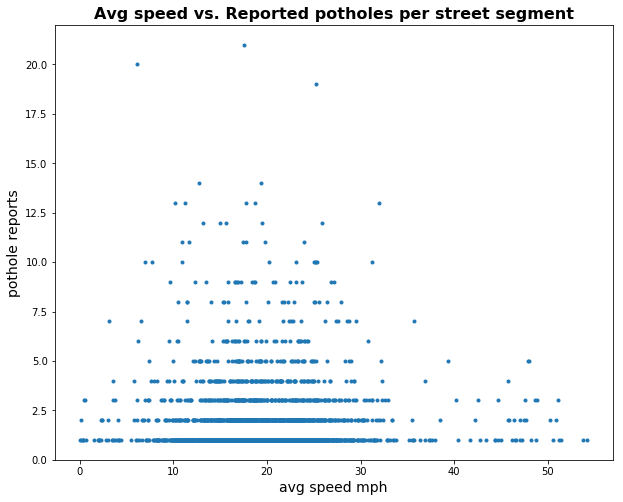

In [17]:
x = df_merged_month['avg_speed']
y = df_merged_month['Service Request Number']
plt.figure(figsize =(10,8))
plt.plot(x,y,'.')
plt.title('Avg speed vs. Reported potholes per street segment', fontsize=16, fontweight='bold')
plt.xlabel('avg speed mph', fontsize=14)
plt.ylabel('pothole reports', fontsize=14)
plt.show()

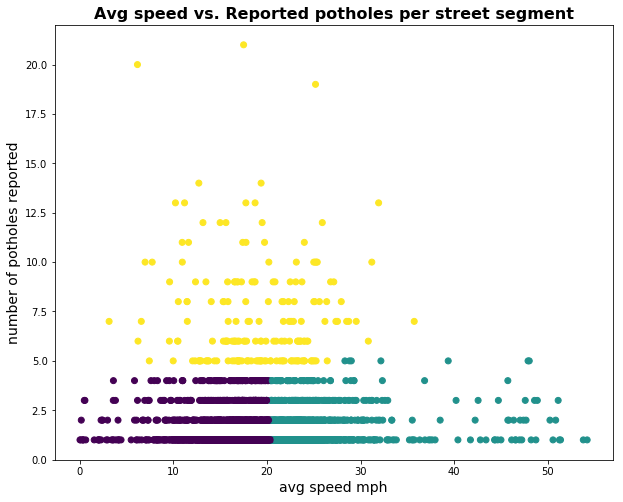

In [18]:
d1 = np.array(df_merged_month['avg_speed'])
d2 = np.array(df_merged_month['Service Request Number'])

# Whiten Data
d1w = whiten(d1)
d2w = whiten(d2)

data = np.vstack([d1w, d2w]).T
km = KMeans(n_clusters=3, random_state=13)
km.fit(data)

# check out the clusters that KMeans found
plt.figure(figsize = (10,8))
plt.scatter(d1, d2, c=km.labels_)
plt.xlabel('average speed mph')
plt.ylabel('pothole reports')

# Add title, labels and legend
plt.title('Avg speed vs. Reported potholes per street segment', fontsize=16, fontweight='bold')
plt.xlabel('avg speed mph', fontsize=14)
plt.ylabel('number of potholes reported', fontsize=14)


plt.show()

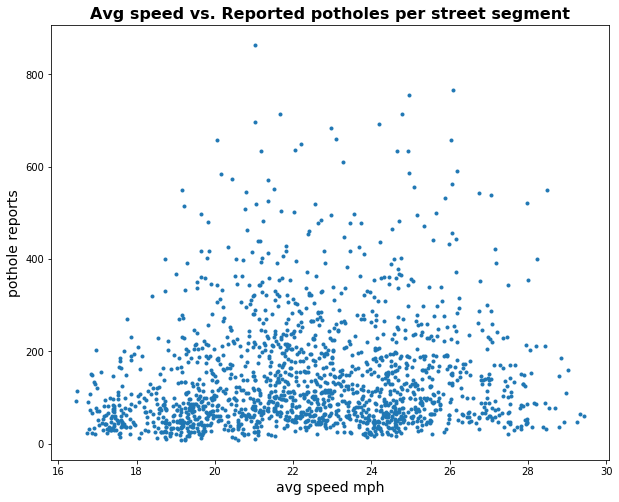

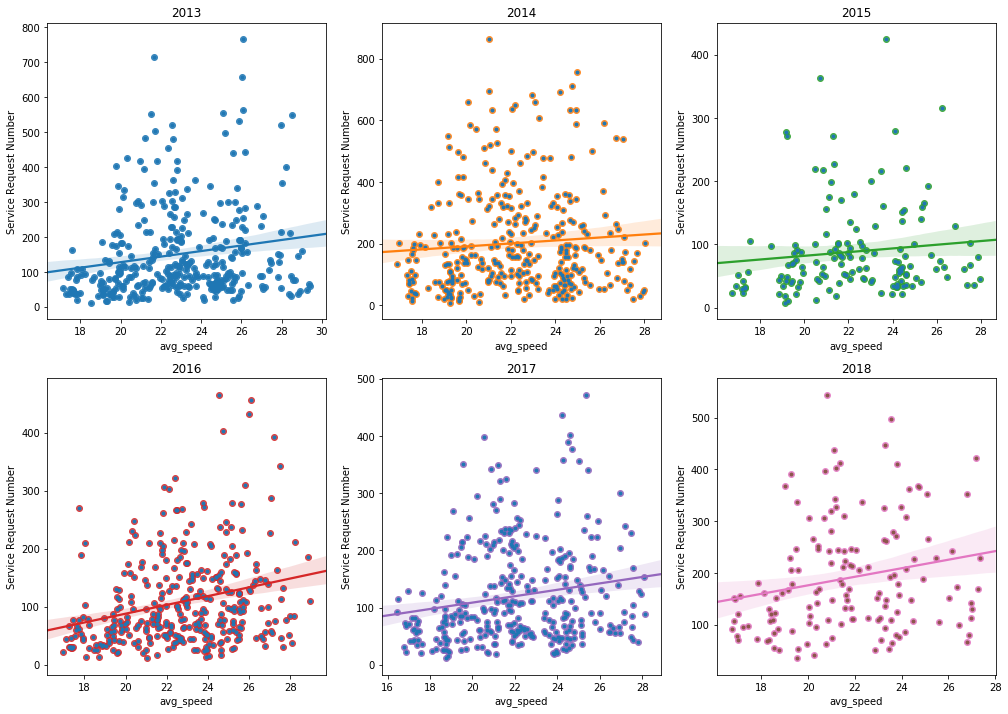

In [19]:
x = df_rm['avg_speed']
y = df_rm['Service Request Number']
plt.figure(figsize =(10,8))
plt.plot(x,y,'.')
plt.title('Avg speed vs. Reported potholes per street region', fontsize=16, fontweight='bold')
plt.xlabel('avg speed mph', fontsize=14)
plt.ylabel('pothole reports', fontsize=14)
plt.show()

df_2013 = df_rm.set_index('DATE').loc['2013-01-01':'2013-12-31']
df_2014 = df_rm.set_index('DATE').loc['2014-01-01':'2014-12-31']
df_2015 = df_rm.set_index('DATE').loc['2015-01-01':'2015-12-31']
df_2016 = df_rm.set_index('DATE').loc['2016-01-01':'2016-12-31']
df_2017 = df_rm.set_index('DATE').loc['2017-01-01':'2017-12-31']
df_2018 = df_rm.set_index('DATE').loc['2018-01-01':'2018-12-31']

f = plt.figure(figsize=(17,12))
ax1 = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
ax6 = f.add_subplot(236)

ax1.plot(df_2013['avg_speed'], df_2013['Service Request Number'], '.')
ax1.set_title("2013")
sns.regplot(df_2013['avg_speed'], df_2013['Service Request Number'], ax=ax1)
ax2.plot(df_2014['avg_speed'], df_2014['Service Request Number'], '.')
ax2.set_title("2014")
sns.regplot(df_2014['avg_speed'], df_2014['Service Request Number'], ax=ax2)
ax3.plot(df_2015['avg_speed'], df_2015['Service Request Number'], '.')
ax3.set_title("2015")
sns.regplot(df_2015['avg_speed'], df_2015['Service Request Number'], ax=ax3)
ax4.plot(df_2016['avg_speed'], df_2016['Service Request Number'], '.')
ax4.set_title("2016")
sns.regplot(df_2016['avg_speed'], df_2016['Service Request Number'], ax=ax4)
ax5.plot(df_2017['avg_speed'], df_2017['Service Request Number'], '.')
ax5.set_title("2017")
sns.regplot(df_2017['avg_speed'], df_2017['Service Request Number'], ax=ax5)
ax6.plot(df_2018['avg_speed'], df_2018['Service Request Number'], '.')
ax6.set_title("2018")
sns.regplot(df_2018['avg_speed'], df_2018['Service Request Number'], ax=ax6)

plt.show()


In [20]:
stats.pearsonr(df_rm['avg_speed'], df_rm['Service Request Number'])

(0.1296056362386812, 9.608776828804525e-08)

Suggests a (very weak) positive correlation, which is the opposite of what we expected. 

A possible consideration is the traffic speed metric itself: a higher speed could mean less congestion but also busier streets. And since region isn't limited to arterial roadways like the street segment data is, it inherently covers a broader spectrum of roads and areas. 

<b>Drop in Traffic Speeds</b>

In [21]:
avgspeed_reg_year = avgspeed_reg.set_index('DATE').groupby([pd.Grouper(freq="Y"), pd.Grouper("REGION_ID")]).mean().reset_index()
df_reg_year = df_reg.set_index('DATE').groupby([pd.Grouper(freq="Y"), pd.Grouper("REGION_ID")])['Service Request Number'].count().reset_index()
df_ry = pd.merge(df_reg_year,avgspeed_reg_year,on = ['DATE','REGION_ID'])
df_ry = df_ry.set_index('DATE')
df_ry_2017 = df_ry.loc['2017-01-01':'2017-12-31'].reset_index()
df_ry_2016 = df_ry.loc['2016-01-01':'2016-12-31'].reset_index()
df_ry_2014 = df_ry.loc['2014-01-01':'2014-12-31'].reset_index()


In [22]:
#Make a dataframe of percent change in requests, percent change in potholes reported

df_1617 = pd.merge(df_ry_2017, df_ry_2016, on=['REGION_ID'])
df_1617.head()
df_1617.columns=['Date_2017', 'REGION_ID', 'Request_2017', 'Speed_2017', 'Date_2016', 'Request_2016', 'Speed_2016']
df_1617['Speed_Drop'] = (100*(df_1617['Speed_2016']-df_1617['Speed_2017']))/(df_1617['Speed_2016'])
df_1617['Req_Incr'] = (100*(df_1617['Request_2017']-df_1617['Request_2016']))/(df_1617['Request_2016'])

#We skip 2015, since there are about 7 months of data missing in 2015 for traffic speeds. 

df_1416 = df_ry_2014[['REGION_ID', 'avg_speed', 'Service Request Number']]
df_1416['Speed_Drop'] = (100*(df_1416['avg_speed']-df_1617['Speed_2016']))/(df_1416['avg_speed'])
df_1416['Req_Incr'] = (100*(df_1617['Request_2016']-df_1416['Service Request Number']))/(df_1416['Service Request Number'])
df_1617 = df_1617[['Speed_Drop', 'Req_Incr']]
df_1416 = df_1416[['Speed_Drop', 'Req_Incr']]
df_1417 = df_1416.append(df_1617)

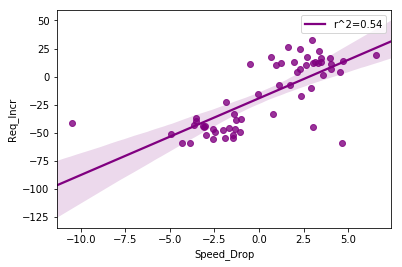

In [23]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_1417['Speed_Drop'],df_1417['Req_Incr'])
ax = sns.regplot(x="Speed_Drop", y="Req_Incr", data=df_1417, color='purple', line_kws={'label':"r^2={0:.2f}".format(r_value**2)})
ax.legend()
plt.show()

# Try to measure in december? or by month

Even though this seems to show a stronger correlation, more analysis has to be done on the effect of time on both of these variables - congestion and pothole reports may both be increasing with time.  

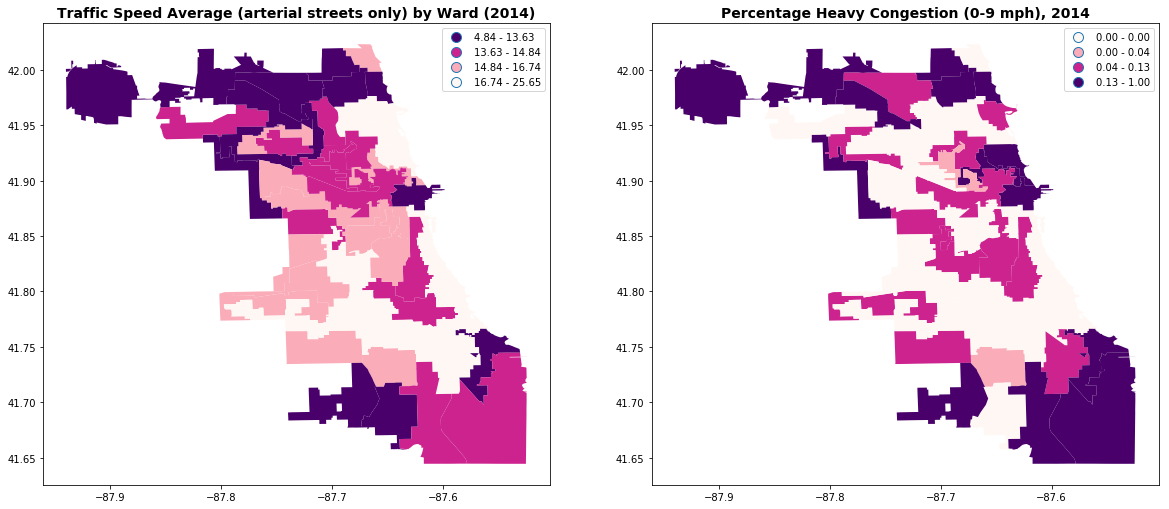

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

temp1 = df_merged_year.set_index('DATE').loc['2014-01-01':'2014-12-31']
temp1 = temp1.groupby('Ward')['avg_speed'].mean().reset_index()
sf = gpd.GeoDataFrame.from_file("Downloads/497_Data/Wards/chiwards.shp")
sf['Ward'] = sf['ward'].astype(int)
response_map1 = pd.merge(sf,temp1,on='Ward')
response_map1.plot(column='avg_speed', scheme='quantiles', k=4, cmap='RdPu_r', legend=True, figsize=(10,20), ax=axes[0])
axes[0].set_title('Traffic Speed Average (arterial streets only) by Ward (2014)', fontsize = 14, fontweight = 'bold')

temp3 = df_merged_year.set_index('DATE').loc['2014-01-01':'2014-12-31']
temp3["has heavy congestion"] = (temp3["avg_speed"]<=9).astype(int)
heavy_count = temp3.groupby("Ward")["has heavy congestion"].sum()
segment_count = temp3.groupby("Ward")["SEGMENTID"].count()
percent_heavy = heavy_count / segment_count
percent_heavy = percent_heavy.reset_index()
percent_heavy.columns=['Ward', 'Percent Heavy']
response_map3 = pd.merge(sf,percent_heavy,on='Ward')
response_map3.plot(column='Percent Heavy', scheme='quantiles', k=4, cmap='RdPu', legend=True, figsize=(10,20), ax=axes[1])
axes[1].set_title('Percentage Heavy Congestion (0-9 mph), 2014', fontsize = 14, fontweight = 'bold')

plt.show()

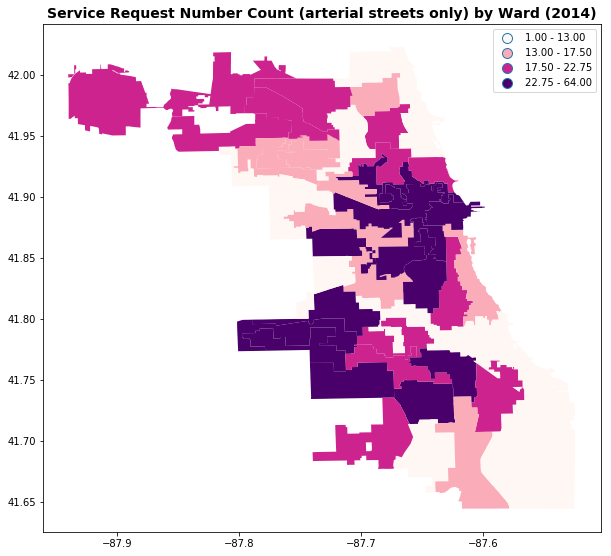

In [25]:
temp2 = df_merged_year.set_index('DATE').loc['2014-01-01':'2014-12-31']
temp2 = temp2.groupby('Ward')['Service Request Number'].count().reset_index()
response_map2 = pd.merge(sf,temp2,on='Ward')
ax2 = response_map2.plot(column='Service Request Number', scheme='quantiles', k=4, cmap='RdPu', legend=True, figsize=(10,20))
ax2.set_title('Service Request Number Count (arterial streets only) by Ward (2014)', fontsize = 14, fontweight = 'bold')
plt.show()

<b>Notes</b>: 

Traffic segment data is limited to arterial streets (no freeways or highways)

From CDOT: "Speed is compared to a 0-9, 10-20, and 21 & over scale to display heavy, medium, and free flow conditions for the traffic segment"

Need to look at other variables such as road conditions and weather in combination wtih traffic, to see if that gives a better picture of traffic's effect on pothole occurence. 
